In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

from bs_helpers import *
from bs_gameclass import *
from utils import *

SX = 10
NSHIPS = 6

In [3]:

def create_sea_ships(shipnum=(0, 0, 4, 3, 2, 1), seed=None): # diese funktion ist anders als die bei unet!!
    'Creates a sea with random ships on it'
    rng = random.Random(seed)
    sea = np.zeros((SX, SX))
    ships = np.zeros((sum(shipnum), SX, SX))
    k = 0
    for l in [5,4,3,2]: # Länge
        n = shipnum[l] # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = rng.random() < 0.5
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(0, 2, 1)
                px = rng.randint(0, SX-l)
                py = rng.randint(0, SX-1)
                if sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                ships[k, px:px+l, py] = 1
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(0, 2, 1)
                k += 1
                break
    return sea, ships

In [4]:
#sea, ships = create_sea_ships((0, 0, 0, 0, 0, 6))
#sea, ships = create_sea_ships(findShipNum())
#sea, ships = njit_create_sea_ships(findShipNum())
#plot_ships(ships, np.ones((10,10)))

In [4]:

@njit(cache=True)
def njit_create_sea_ships(shipnum=(0, 0, 4, 3, 2, 1)): # diese funktion ist anders als die bei unet!!
    'Creates a sea with random ships on it'
    sea = np.zeros((SX, SX))
    ships = np.zeros((sum(shipnum), SX, SX))
    k = 0
    for l in [5,4,3,2]: # Länge
        n = shipnum[l] # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = np.random.rand() < 0.5
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(0, 2, 1)
                px = np.random.randint(0, SX+1-l)
                py = np.random.randint(0, SX)
                if sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                ships[k, px:px+l, py] = 1
                if t:
                    sea = sea.T # Transponieren
                    ships = ships.transpose(0, 2, 1)
                k += 1
                break
    return sea, ships

In [5]:

@njit(cache=True)
def findShipNum():
    'Bestimmt eine zufällige Zahl an Schiffen, die auf die See platziert werden sollen'
    shipnum = np.random.multinomial(NSHIPS, 6*[1/6]) # 6 schiffe, verteilt auf 6 mögliche längen
    shipnum[:2] = 0 # länge null und länge eins sollen nicht vorkommen
    return shipnum

@njit(cache=True)
def sinksShip(ships, det, ij):
    det = det.copy()
    det[ij] = 1
    sn = 0
    for k in range(len(ships)):
        if ships[k][ij]:
            if np.sum(ships[k,:,:] * (1-det)) == 0:
                sn = 1
    return sn

@njit(cache=True)
def play(nmoves):
    'Plays a game and returns the game history and the sea'
    shipnum= findShipNum()
    sea, ships = njit_create_sea_ships(shipnum)
    det = np.zeros_like(sea)
    moves = []
    hits = []
    sunken = []
    for _ in range(nmoves):
        vms = [ (i,j) for i in range(SX) for j in range(SY) if (1-det[i,j]) ]
        k = np.random.randint(len(vms))
        ij = vms[k]
        det[ij] = 1
        moves.append(ij)
        hits.append(sea[ij])
        sunken.append(sinksShip(ships, det, ij))
    
    # target is 1 if a ship is at ij, and is 2 if a shot at ij sinks a ship
    target = np.zeros((SX, SX))
    for i in range(SX):
        for j in range(SX):
            target[i,j] = sea[i,j]
            if target[i,j]:
                target[i,j] += sinksShip(ships, det, (i,j))
    return list(zip(moves, hits, sunken)), target, shipnum#, det, ships



def encode_shipnum(shipnum):
    'Encodes the number of ships on the sea into a one hot format'
    z = np.zeros((NSHIPS+1)*6)
    for k in range(6):
        i = shipnum[k]
        z[(NSHIPS+1)*k + i] = 1.
    return z
    

def encode(hist, shipnum):
    'Encodes the visible information to an input to the neural network'
    'First data point is the number of ships followed by the coordinates'
    'of the shots and the information of a ship was hit and if it sank'
    def bits(k):
        return [ float((k>>i)&1) for i in range(8) ]
    
    #x = np.zeros((SX**2, 2*SX+2+8))
    NBUFF = 100
    x = np.zeros((1+SX**2, NBUFF))
    x[0, :6*(NSHIPS+1)] = encode_shipnum(shipnum)
    
    for k in range(len(hist)):
        (i,j),r,sn = hist[k]
        x[k+1, i] = 1
        x[k+1, SX+j] = 1
        x[k+1, 2*SX] = r
        x[k+1, 2*SX+1] = sn
        x[k+1, -8:] = np.asarray(bits(k+1))
    return x
    

def batchgen(size=32):
    while True:
        xs, ys = [], []
        for _ in range(size):
            hist, target, shipnum = play(np.random.randint(SX**2))
            xs.append(encode(hist, shipnum))
            ys.append(target)
        yield np.array(xs), np.array(ys)

In [7]:
bg = batchgen()
xs, ys = next(bg)

In [8]:
xs.shape

(32, 101, 100)

In [6]:
from bsp_transformer import *
from torch_optimizer import Lookahead, Yogi
net = Net()
#net.optim = torch.optim.Adam(lr=1e-3, params=net.parameters())
net.optim = Lookahead(Yogi(lr=3e-3, betas=(0.9, 0.98), params=net.parameters()))
net.losses = []
net.iters = 0

In [7]:
net.load_state_dict(torch.load('data/bsp_transformer_071223.dat'))

<All keys matched successfully>

In [11]:
def loss():
    xs, ys = next(bg)
    xs, ys = np2t(xs, ys)
    yp = net(xs)
    yp = yp.view(-1, 3)
    ys = ys.view(-1)
    loss = F.nll_loss(torch.log(yp+1e-12), ys.long())
    return loss

loss()

tensor(0.1453, device='cuda:0', grad_fn=<NllLossBackward0>)

In [12]:
def lrscheduler(i):
    warmupsteps = 200
    maxlr = 3e-3
    lr = min(maxlr, i/warmupsteps*maxlr)
    for g in net.optim.param_groups:
        g['lr'] = lr

In [ ]:
BCE = nn.BCELoss()
losses = []
bg = batchgen()

for k in trange(999999):

    lrscheduler(net.iters)
    l = loss()
    l.backward()
    net.optim.step()
    net.zero_grad()
    #print(loss)
    losses.append(l.item())

    if k%200 == 0:
        ##xs, ys, yp = t2np(xs, ys, yp)
        net.losses.append((net.iters, np.mean(losses)))
        losses = []
        plt.plot(*zip(*net.losses))
        #plt.ylim([0,0.1])
        plt.grid()
        plt.show()
        torch.save(net.state_dict(), 'data/bsp_transformer_071223.dat')
        
    net.iters += 1


In [9]:
def show_hist(hist, shipnum, ax):
    lines = []
    for tpl in hist:
        tpl = (tpl[0], int(tpl[1]), tpl[2])
        line = f'shot at ({tpl[0][0]}, {tpl[0][1]})'
        if tpl[1] and tpl[2]: line += ', ship sunk!'
        elif tpl[1]: line += ', ship hit'
        #line = repr(tpl)
        lines.append(line)
    if len(lines) > 10:
        lines = lines[-10:]
        lines[0] = '...'
    lines = ['Ship numbers: ' + repr(list(shipnum[2:]))] + lines
    text = '\n'.join(lines)
    ax.text(0, 0.5, text, size=12, va='top')
    plt.imshow(np.ones_like(det), vmin=0., vmax=1., cmap='gray')
    ax.axis('off')

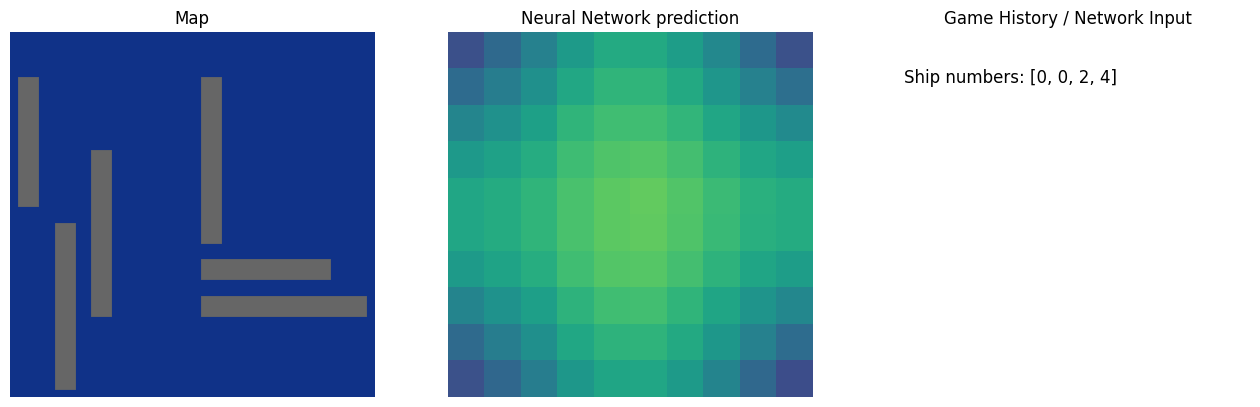

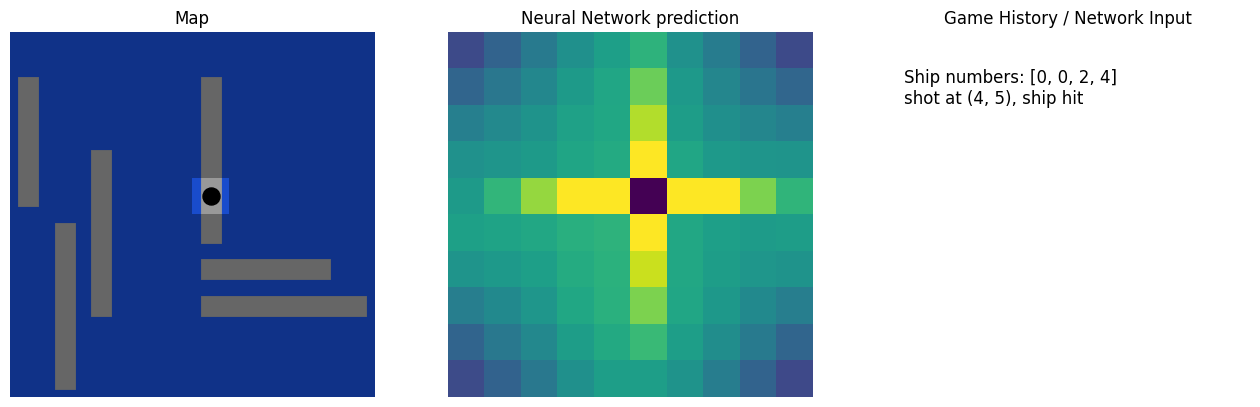

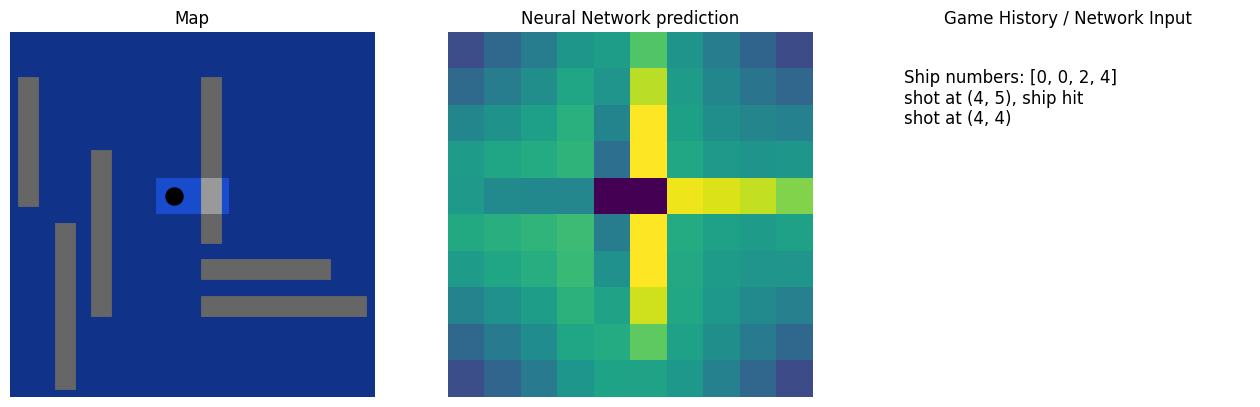

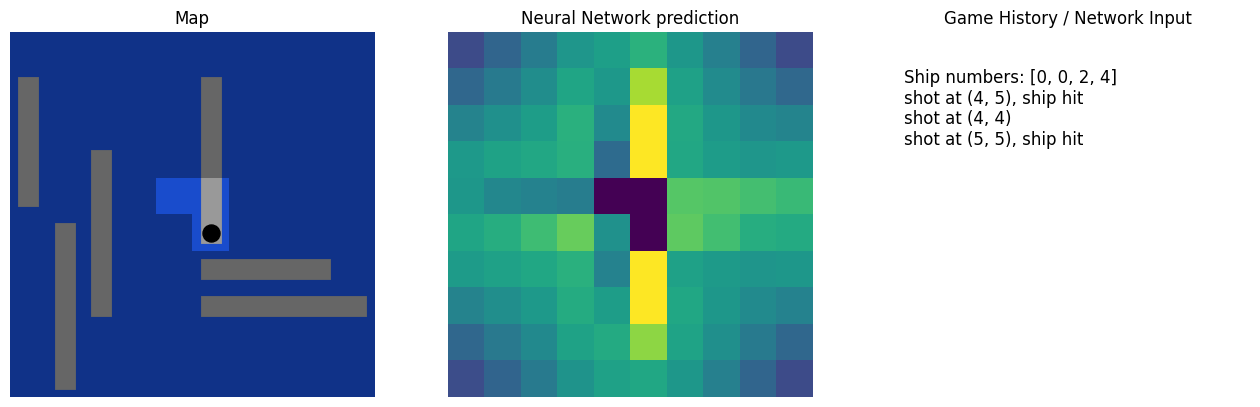

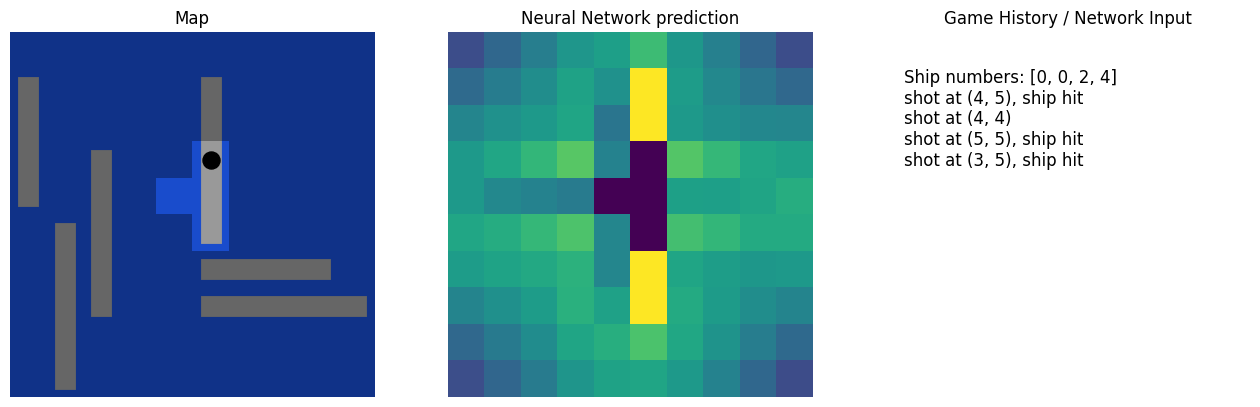

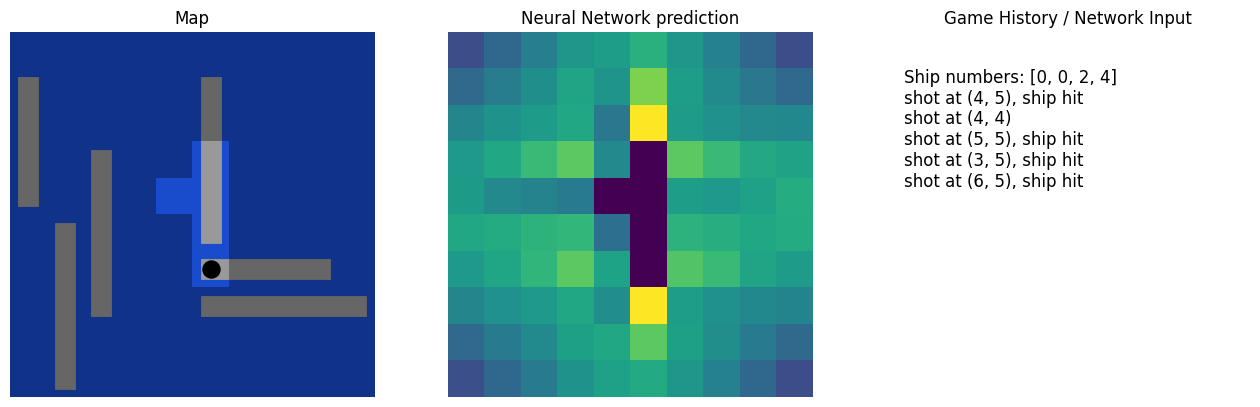

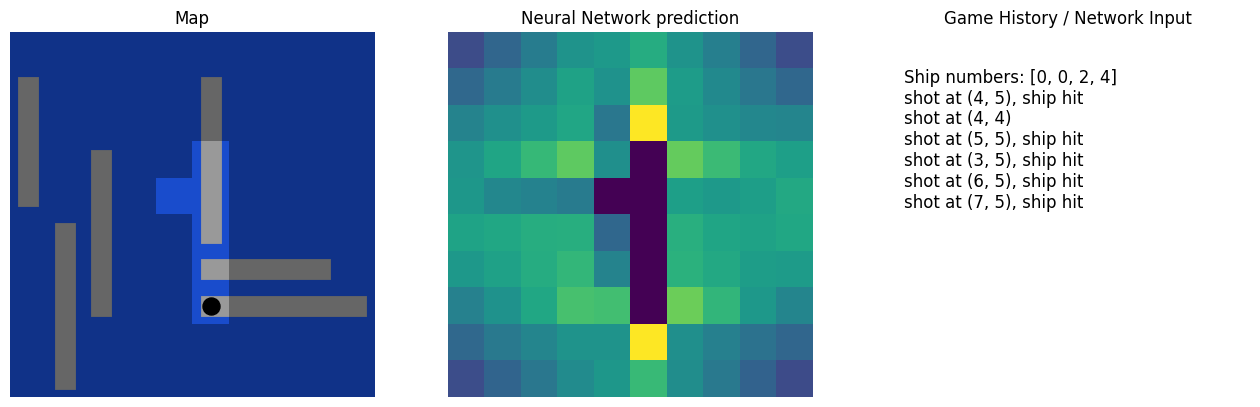

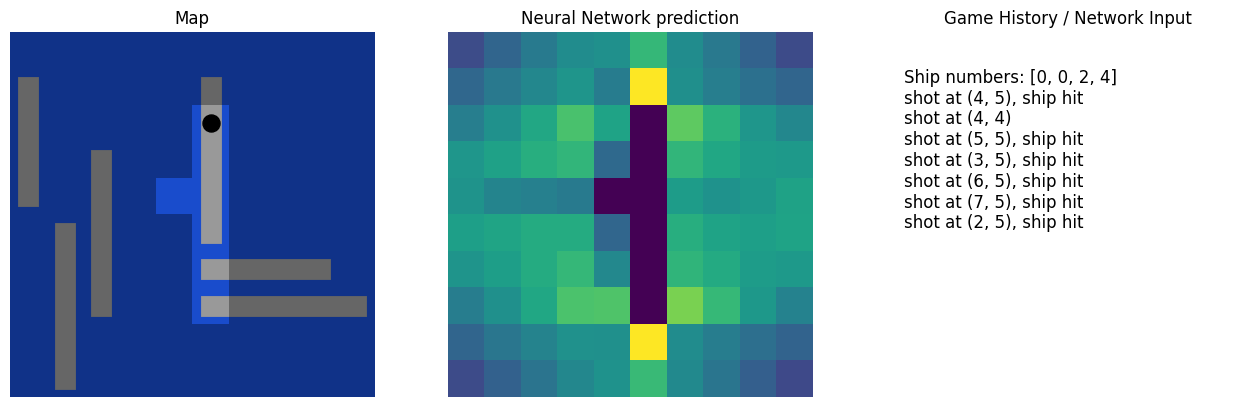

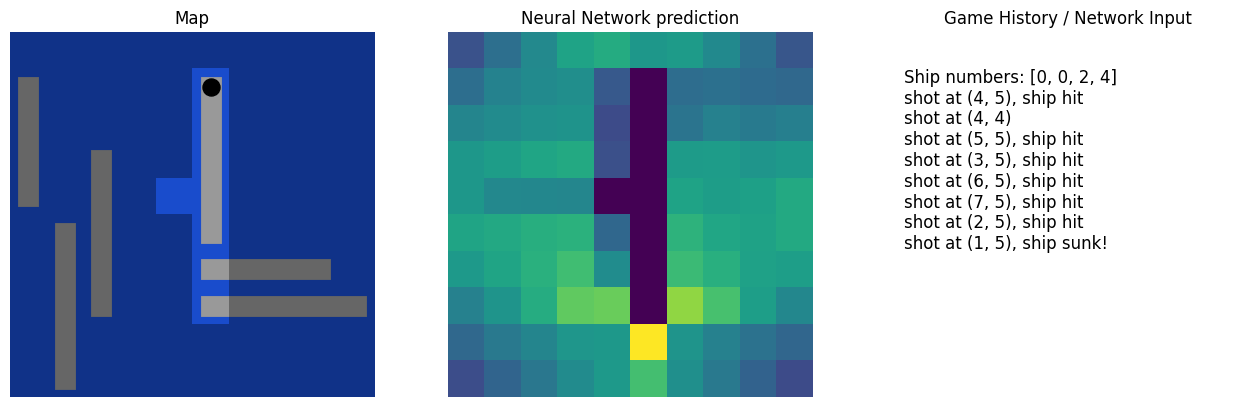

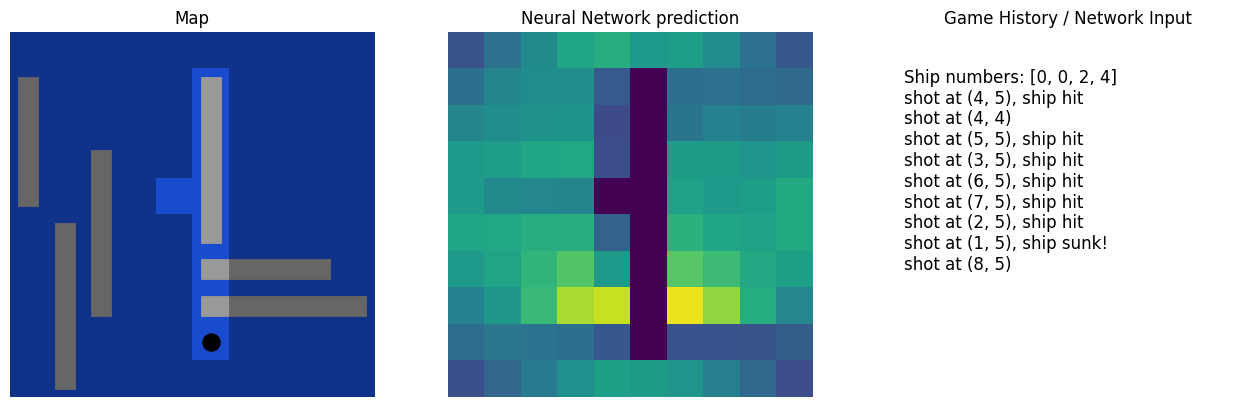

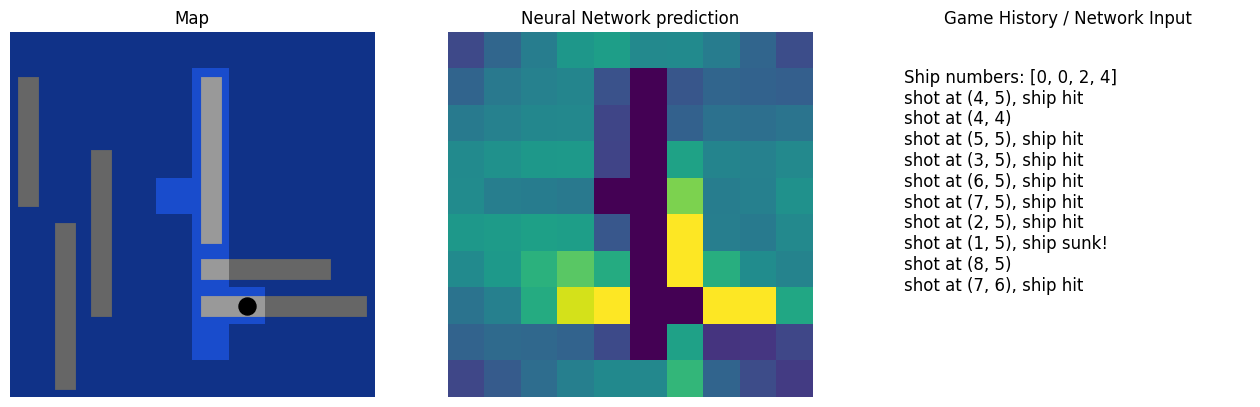

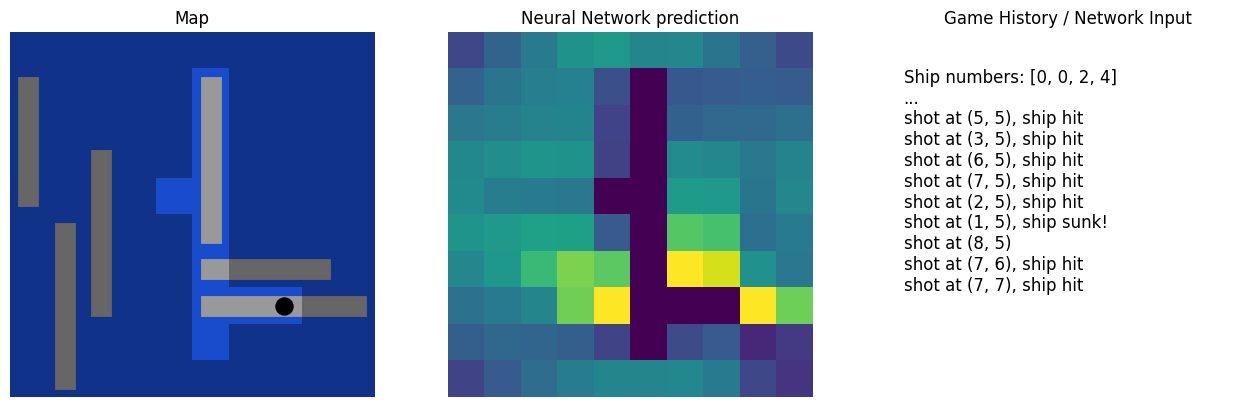

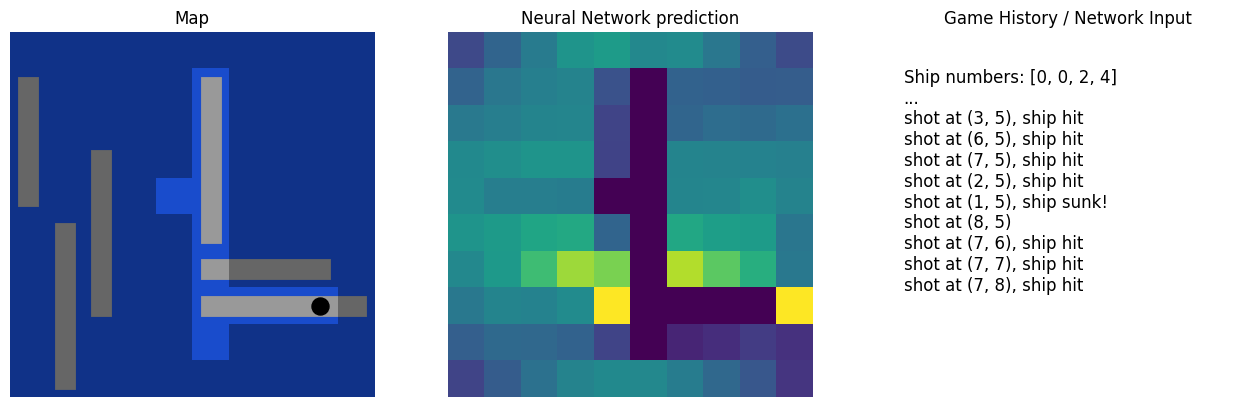

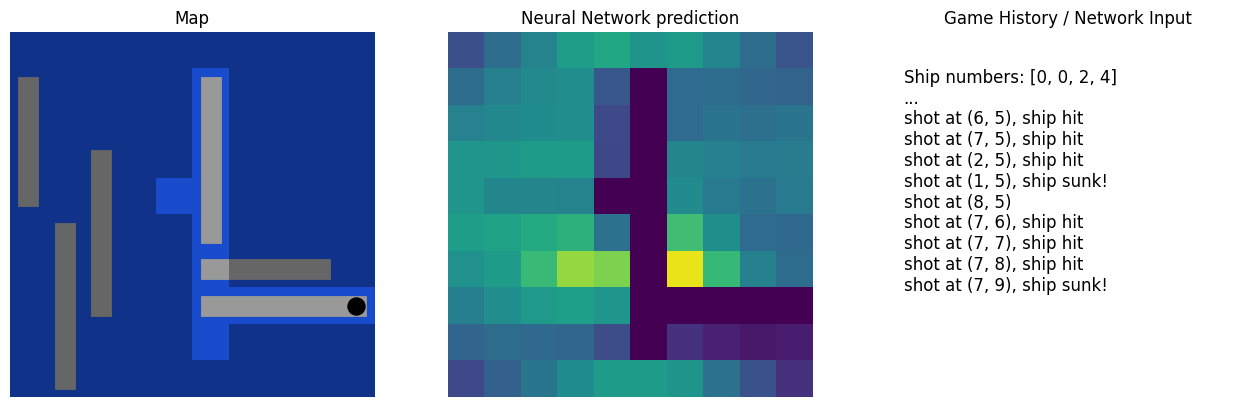

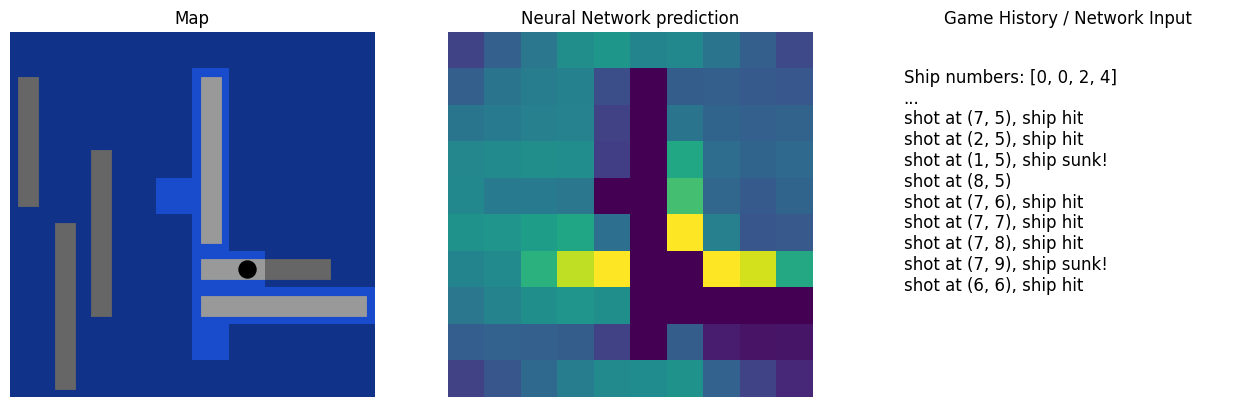

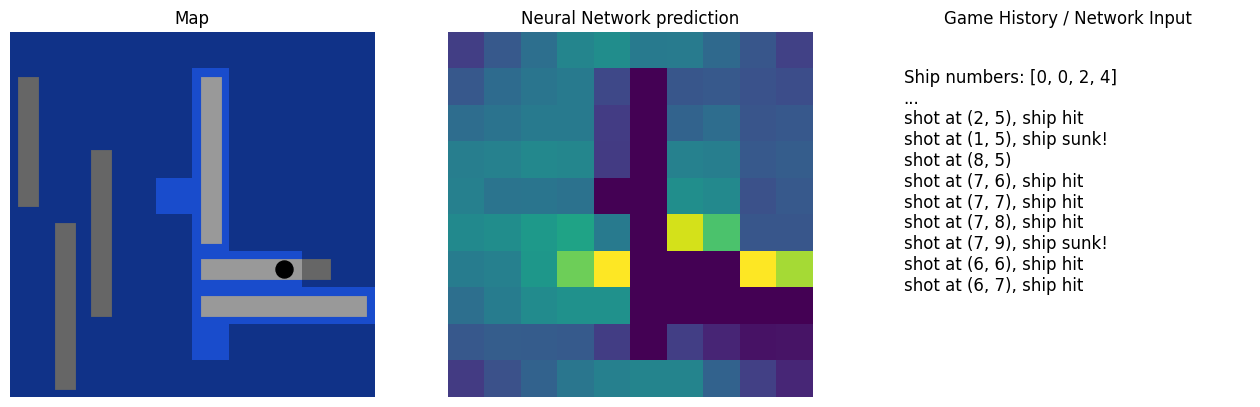

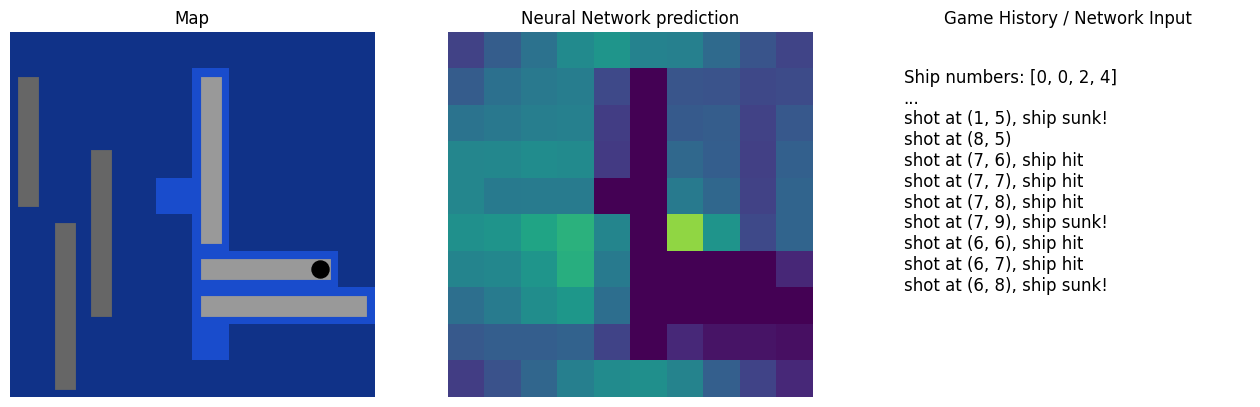

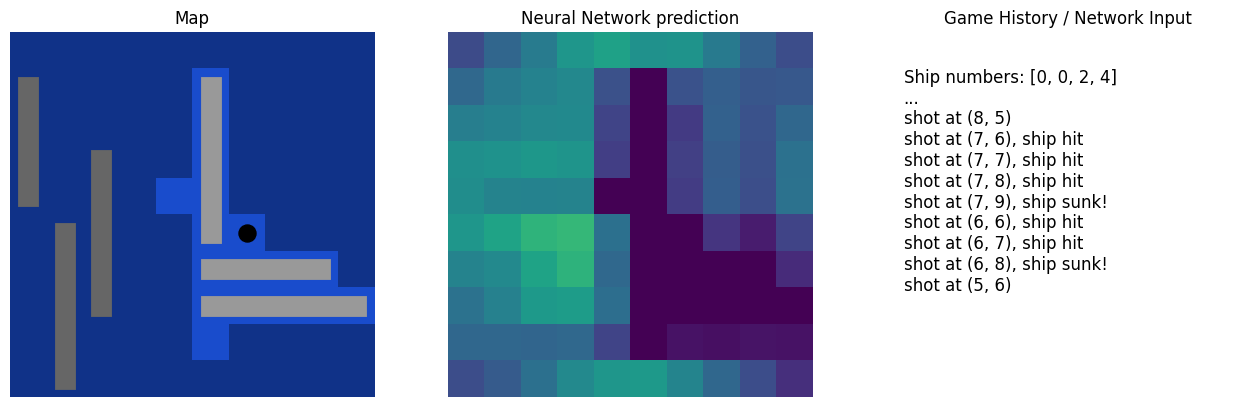

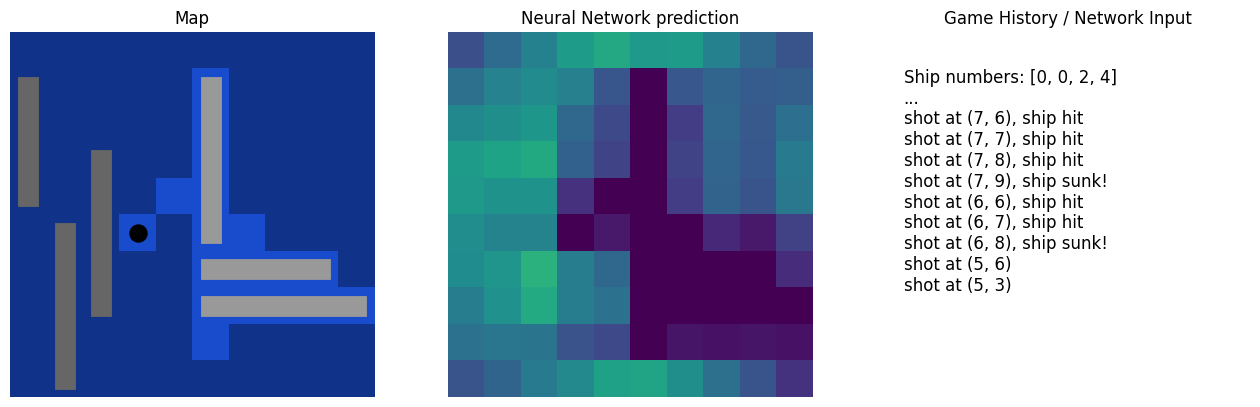

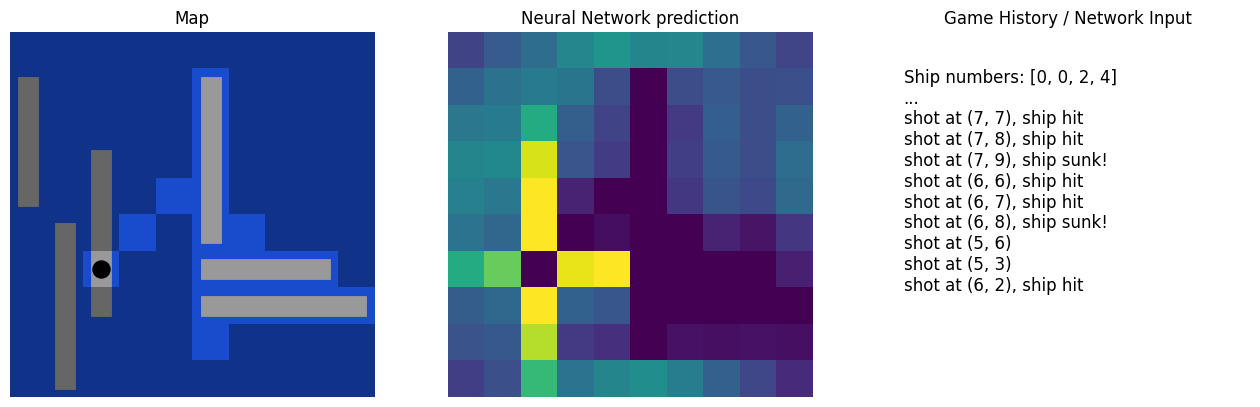

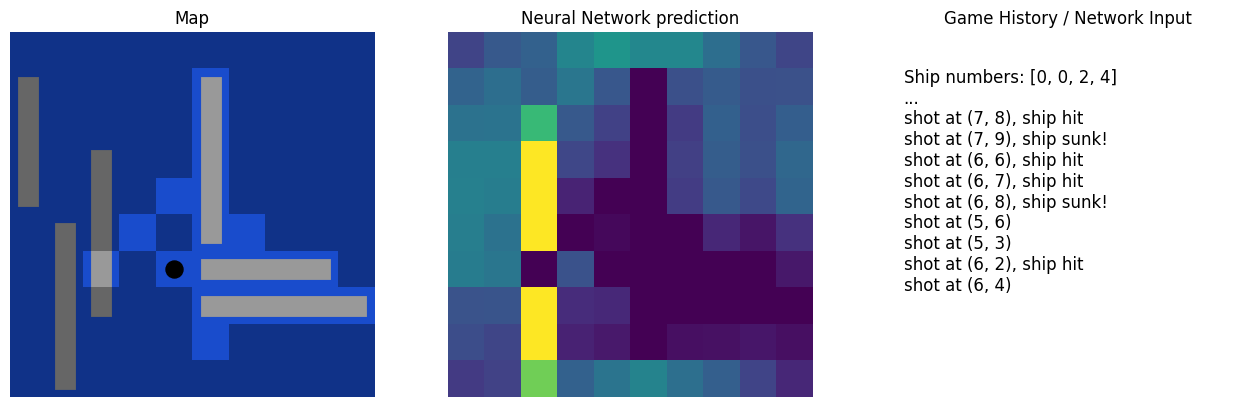

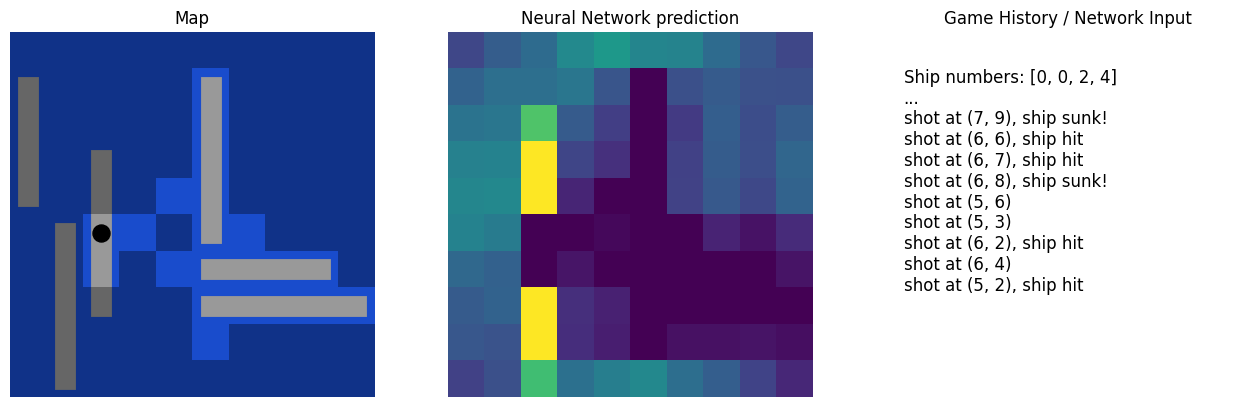

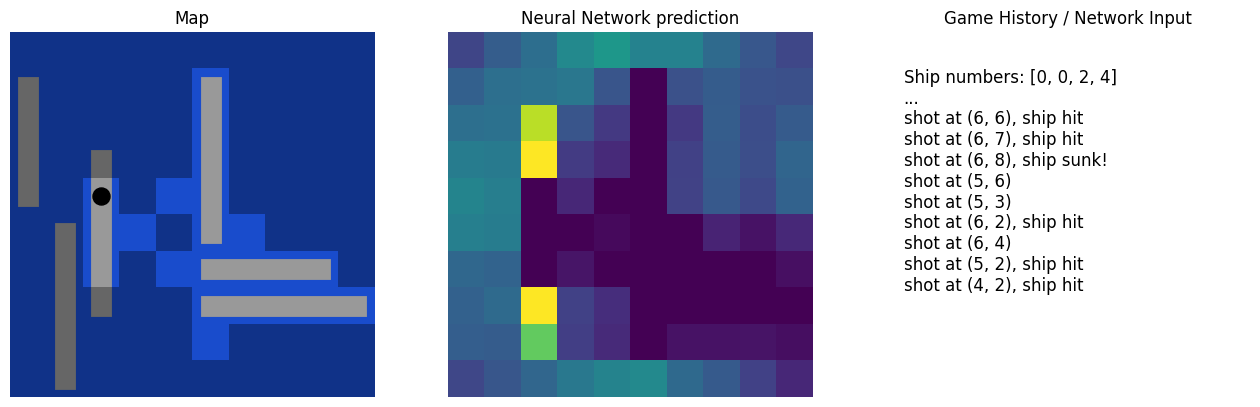

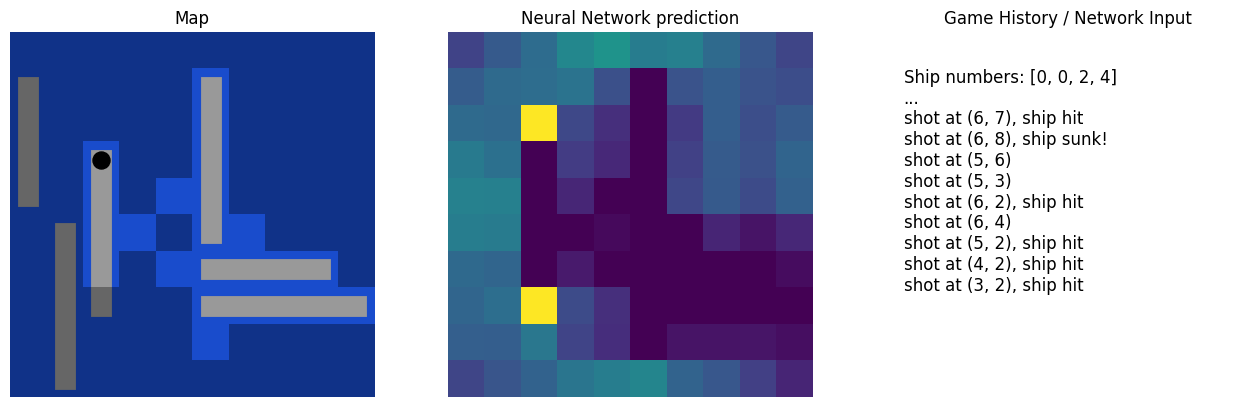

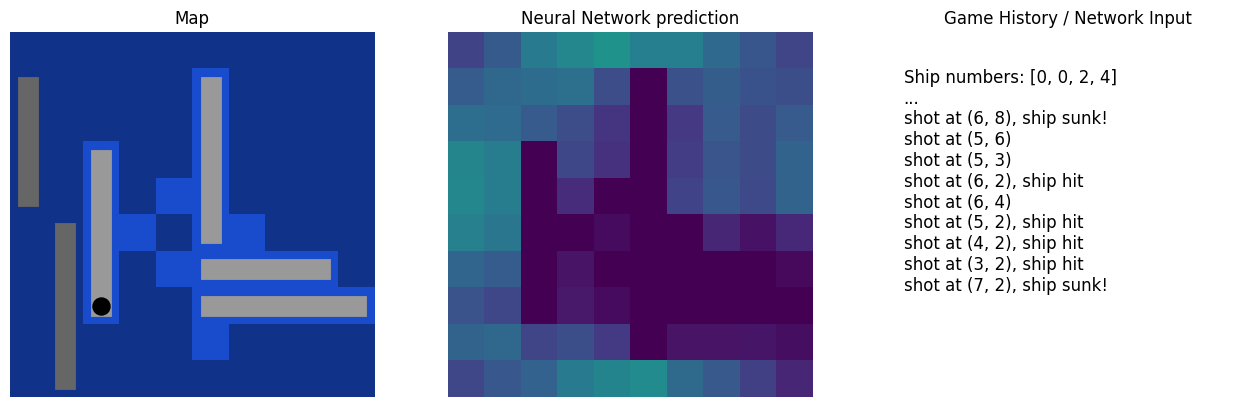

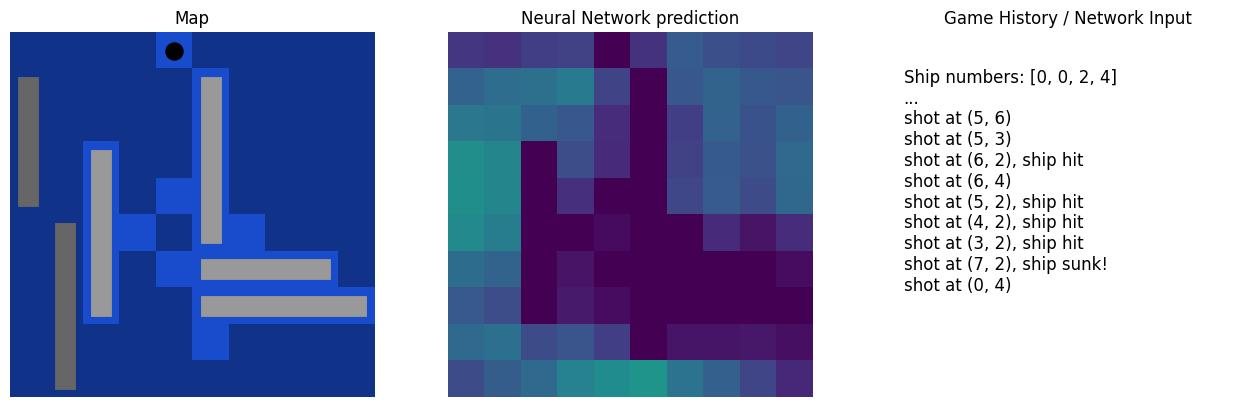

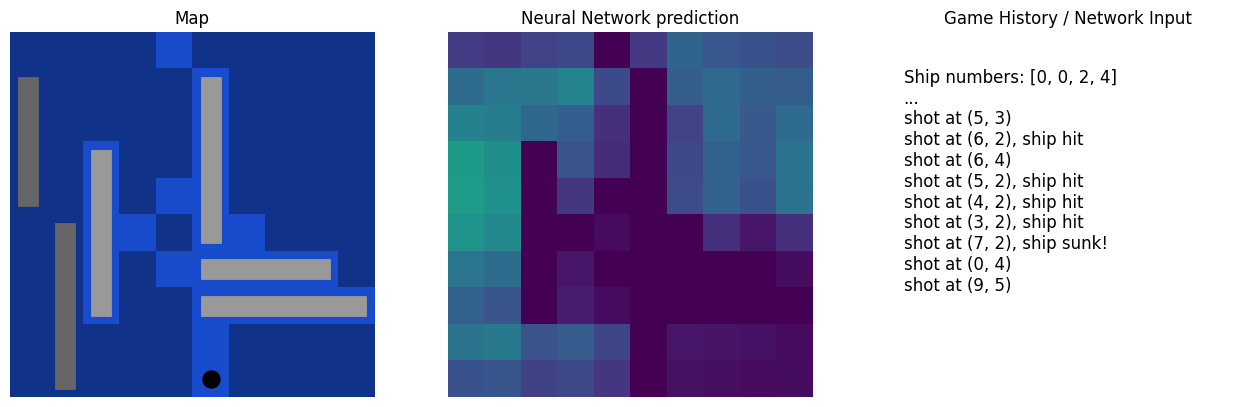

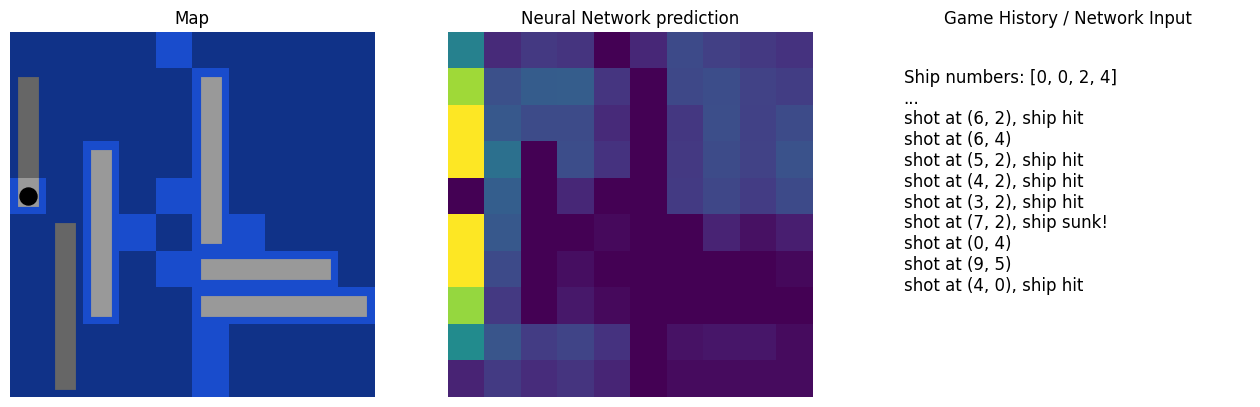

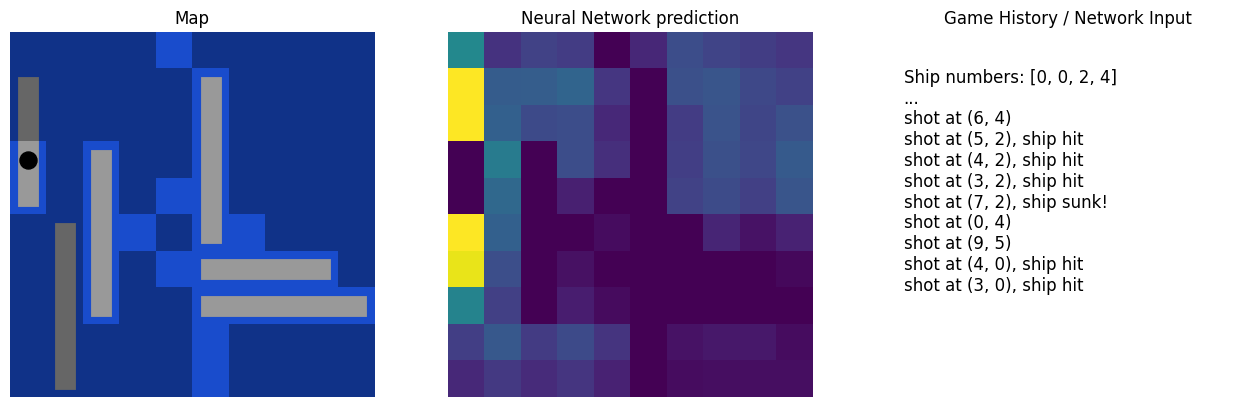

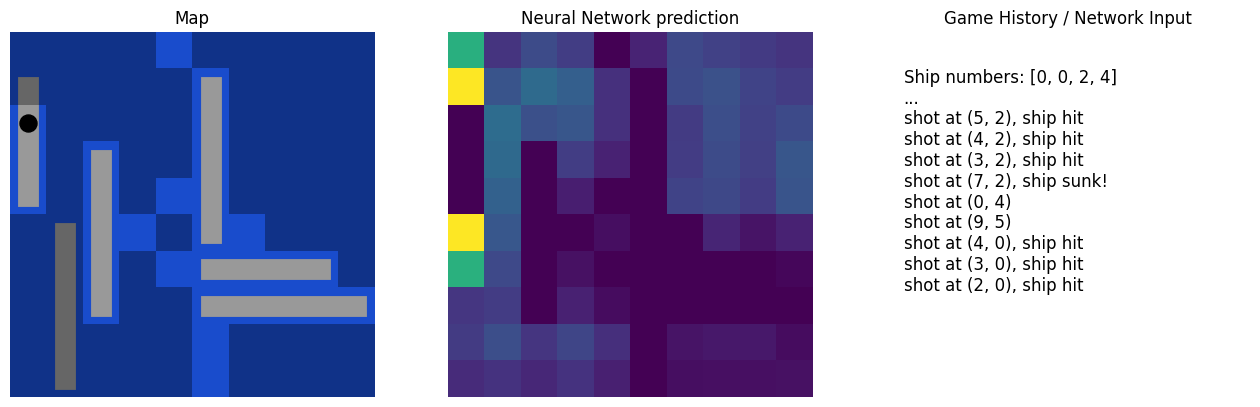

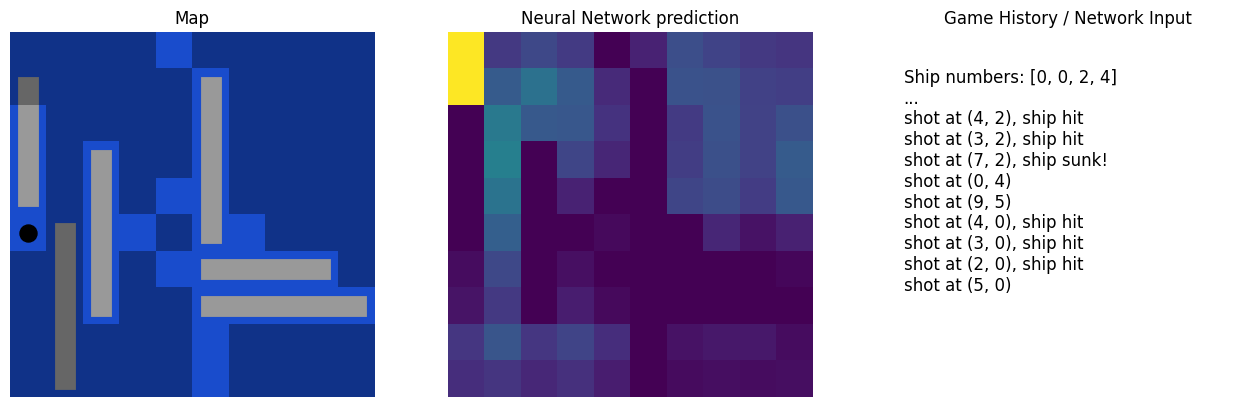

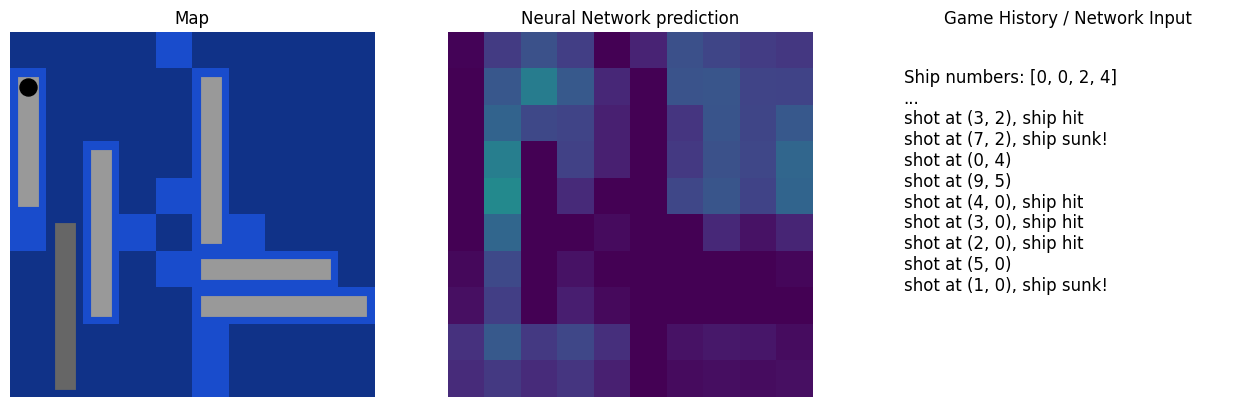

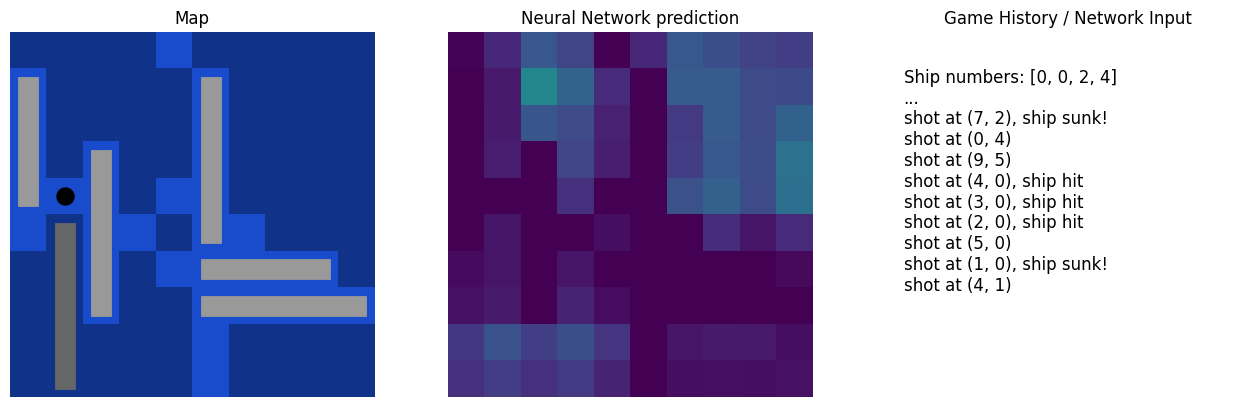

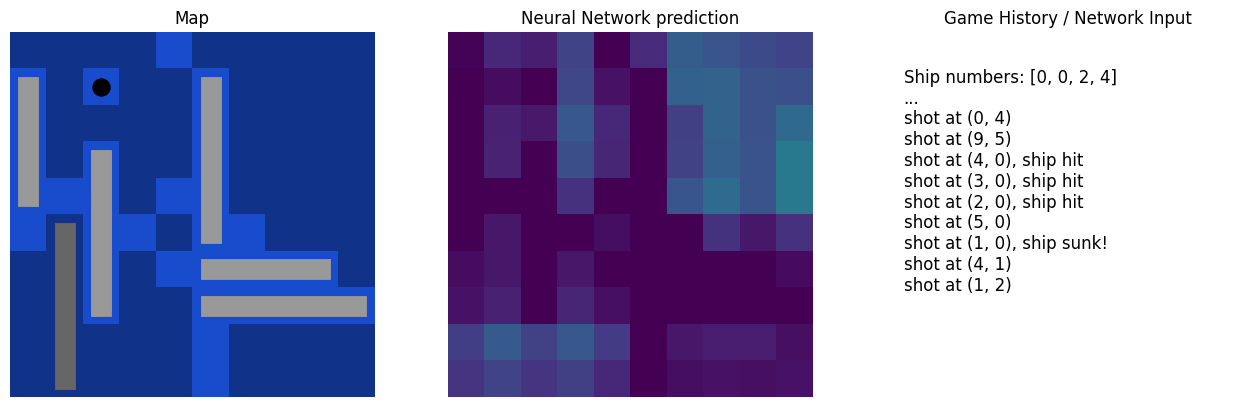

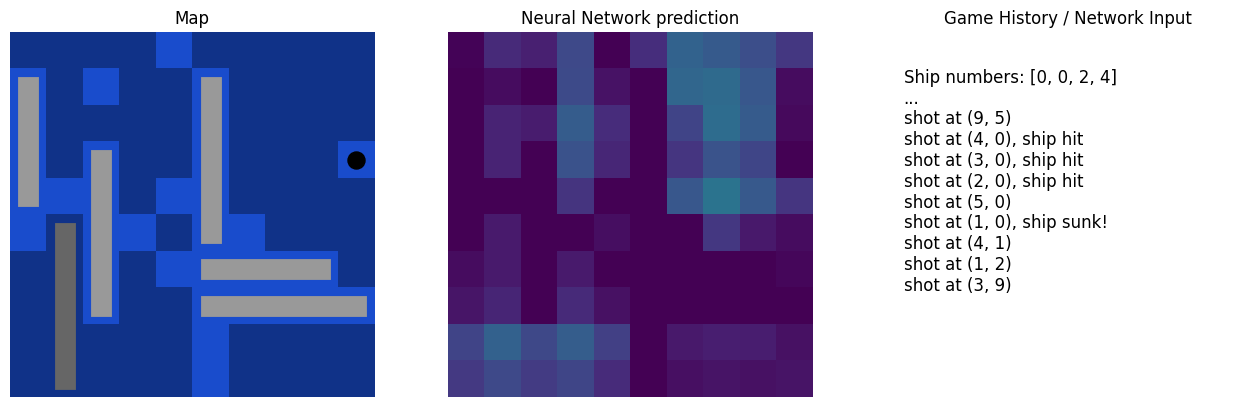

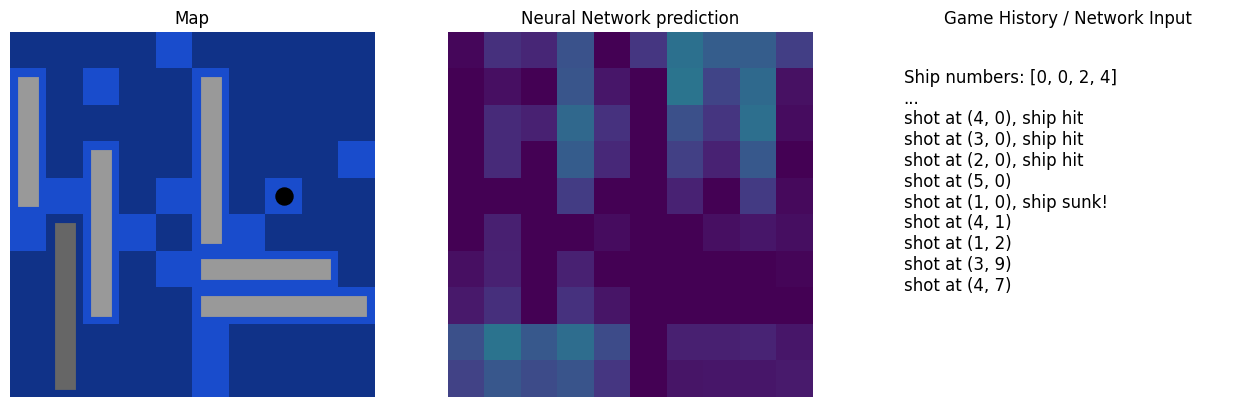

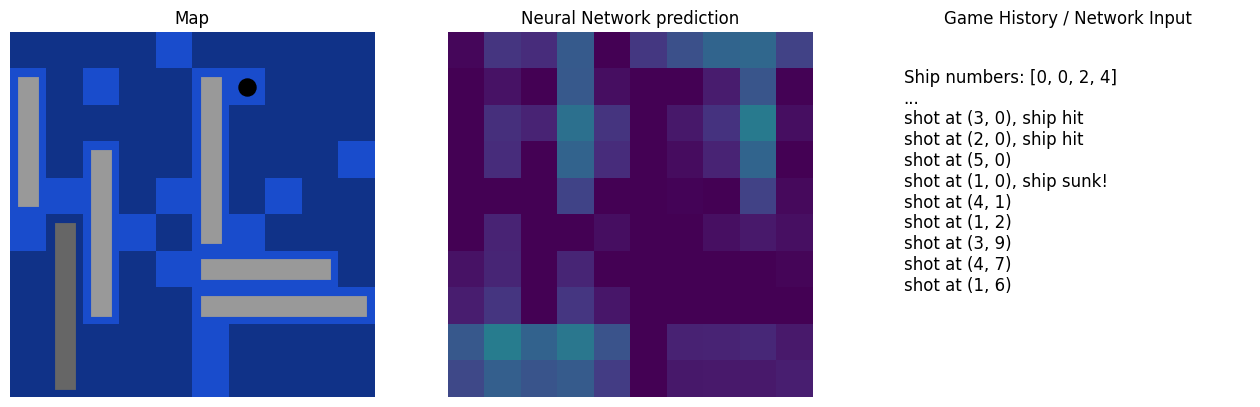

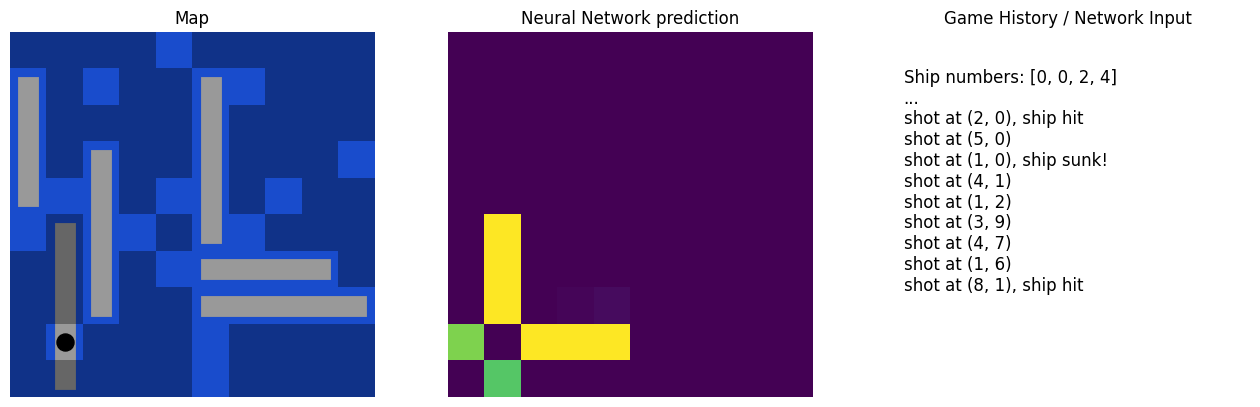

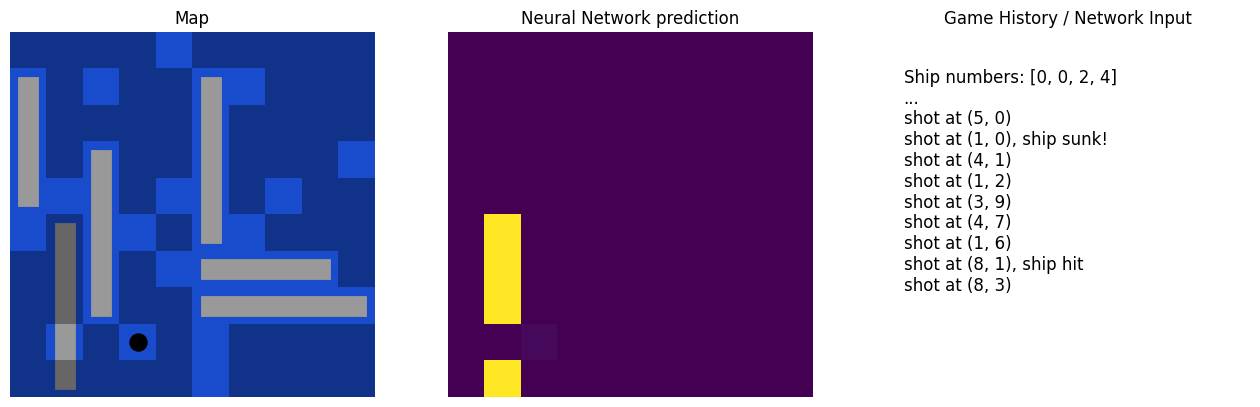

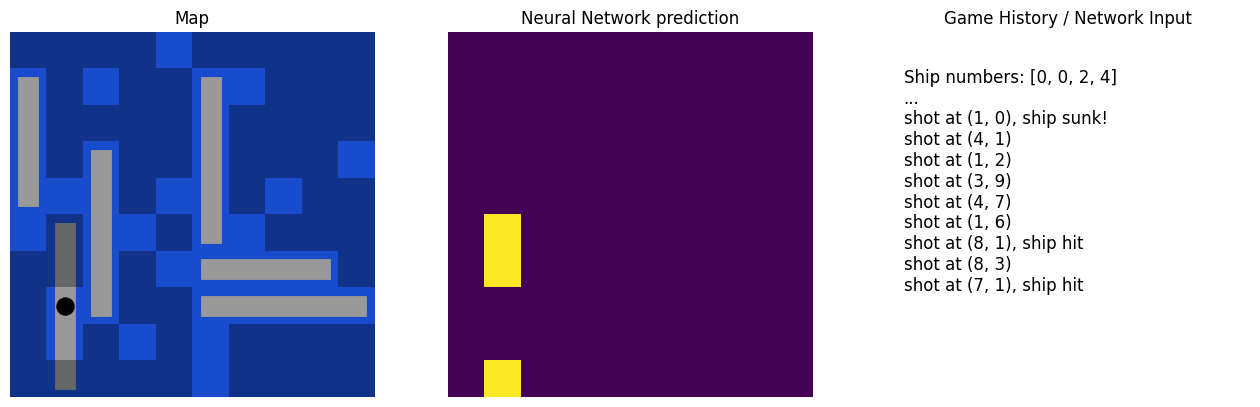

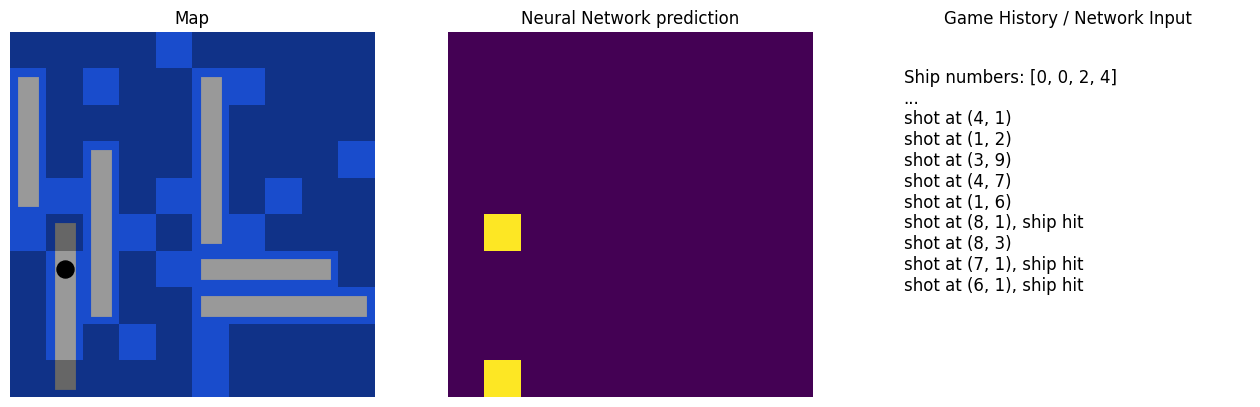

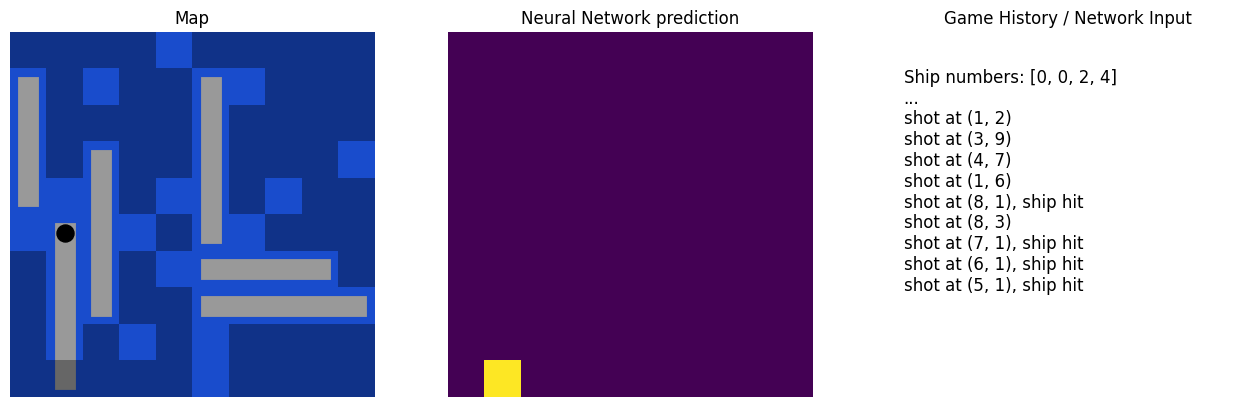

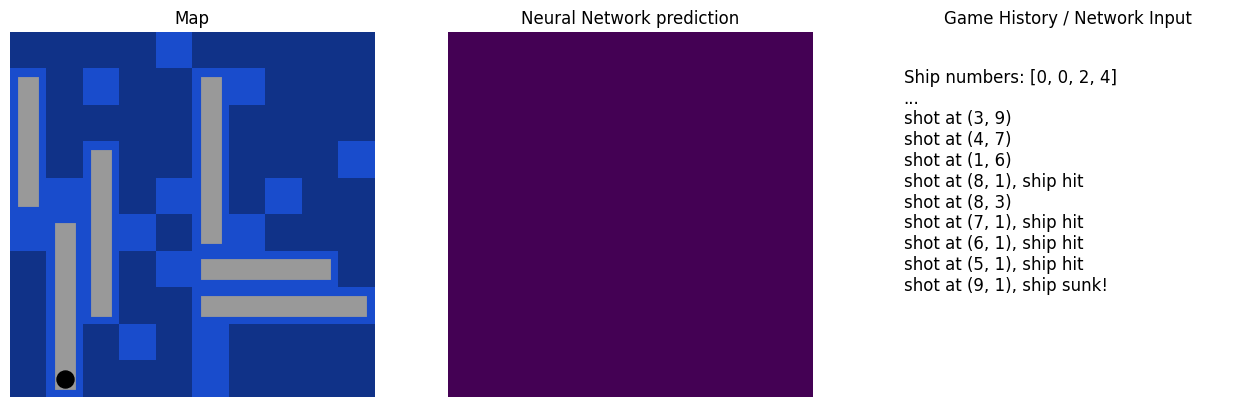

In [10]:
from vidcapture import vidcapture
net.eval()
det = np.zeros((10,10))
shipnum = np.array([0, 0, 0, 0, 2, 4])
sea, ships = create_sea_ships(shipnum, seed=1000)
i,j = [],[]
vc = vidcapture('F:/$Daten/vidcaptures/battleship transformer3/frame%05d.png')
moves = []
hits = []
sunken = []
hist = []
while True:
    yp = t2np(net(np2t([encode(hist, shipnum)]))).reshape((10,10,3))
    prob = yp[:,:,1] + yp[:,:,2]
    ##prob[det > 0] = 0
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
    ax1.title.set_text('Map')
    ax2.title.set_text('Neural Network prediction')
    ax3.title.set_text('Game History / Network Input')
    ax1.axis('off')
    ##plot_sea(sea, det, ax1)
    plot_ships(ships, det, ax1)
    ax1.scatter(j, i, c='black', alpha=1, s=150)
    ax2.axis('off')
    ax2.imshow((prob*(1-det)), vmin=0., vmax=.5)
    show_hist(hist, shipnum, ax3)
    vc.capture()
    plt.show()
    
    if np.sum(det*sea) >= np.sum(sea): break
        
    # Welchen Detektieren??
    prob2 = prob  ##
    prob2[det > 0] = 0
    m = prob2.argmax()
    i, j = m//10, m%10
    det[i,j] = 1.
    
    # history aufzeichnen
    moves.append((i,j))
    hits.append(sea[i,j])
    sunken.append(sinksShip(ships, det, (i,j)))
    hist = list(zip(moves, hits, sunken))
    

In [ ]:
repr(shipnum[2:]) 

In [ ]:

# Viele Spiele spielen und score sehen
from bs_gameclass import *

rs = []
for _ in trange(100):
    s = GameState()
    h, ships = create_sea_ships()
    r = 0
    moves = []
    rewards = []
    sunken = []
    hist = []
    while not GameClass.getEnded(s):
        prob = t2np(net(np2t([encode(hist)]))).reshape((10,10))
        prob[s.det==1] = 0
        ij = argmax2d(prob)
        s = GameClass.getNextState(s, ij, h)
        r += h[ij]*np.mean(1-s.det)
        moves.append((ij))
        rewards.append(h[ij])
        sn = 0
        for l in range(NSHIPS):
            if ships[ij][l]:
                if np.sum(ships[:,:,l] * (1-s.det)) == 0:
                    sn = 1
        sunken.append(sn)
        hist = list(zip(moves, rewards, sunken))
    rs.append(r)

In [ ]:
np.mean(rs)